# City Level - Los Angeles

The study compared OLS and Poisson regression in analyzing daily traffic accident counts in Los Angeles for the year 2022

In the codeblock below set your working directory and library path if necessary

In [1]:
# set current library
# setwd("C:/Users/pngal/OneDrive/PyMyCode/OMSA/ISYE_6414/project/analysis")
# Path to Libraries 
# .libPaths("C:/Users/pngal/R/win-library")

Installing and calling the necessary libraries

In [10]:
# installing necessary packages
#install.packages(c("ggplot2",'dplyr', "readr", "lubridate", "caret"))

library(dplyr)
library(lubridate)
library(car)
library(readr)
#library(here)
library(caret)
library(ggplot2)

# Data collection and manipulation

In [52]:
# check working directory path
getwd()

[1] "C:/Users/pngal/OneDrive/PyMyCode/OMSA/ISYE_6414/project/analysis"

First let us unzip the data files and save them for further analysis.

In [11]:
folder_path <- "data"
zip_file <- "data.zip"

# Check if folder exists; if not, unzip
if (!dir.exists(folder_path)) {
    print("data unzipped")
    unzip(zip_file)
}

[1] "data unzipped"


## LA Holiday Data

In [12]:
la_hol = read.csv("data/LA_Holidays_2022.csv", sep=";")

# formating Date.Occurred to date
la_hol$Date = as.Date(la_hol$Date, format = "%d/%m/%Y")

dim(la_hol)
head(la_hol)

[1] 365   2

,Date,Holiday
,<date>,<int>
1,2022-01-01,0
2,2022-01-02,0
3,2022-01-03,0
4,2022-01-04,0
5,2022-01-05,0
6,2022-01-06,0


## LA International Airport Data

In [13]:
la_air = read.csv("data/Los_Angeles_International_Airport_-_Passenger_Traffic_By_Terminal_20251125.csv")

# converting to date time format
la_air$DataExtractDate = as_date(parse_date_time(la_air$DataExtractDate, "Y b d I:M:S p"))

# converting to date time format
la_air$ReportPeriod = as_date(parse_date_time(la_air$ReportPeriod, "Y b d I:M:S p"))

# converting to numeric
la_air$Passenger_Count = parse_number(la_air$Passenger_Count)

# filtering the year 2022
la_air = la_air %>% filter(year(ReportPeriod) == 2022)

# grouping according to reporting month
la_air = la_air %>% group_by(ReportPeriod) %>% summarise(AirportPassengerCount = sum(Passenger_Count))

# adding a month column
la_air = la_air %>% mutate(Month = month(ReportPeriod))

#print data
la_air

ReportPeriod,AirportPassengerCount,Month
<date>,<dbl>,<dbl>
2022-01-01,3966078,1
2022-02-01,4083155,2
2022-03-01,5213901,3
2022-04-01,5449159,4
2022-05-01,5844997,5
2022-06-01,6133388,6
2022-07-01,6346325,7
2022-08-01,6094699,8
2022-09-01,5630514,9


## LAPD Traffic Collision Data

In [14]:
lapd_tc = read.csv("data/Traffic_Collision_Data_from_2010_to_Present_20251119.csv")

# formating Date.Occurred to date
lapd_tc$Date.Occurred = as.Date(lapd_tc$Date.Occurred, format = "%m/%d/%Y")

# filtering all accidents that occured in 2022
lapd_tc = lapd_tc %>% filter(year(Date.Occurred) == 2022)

#head(lapd_tc)
dim(lapd_tc)

# checking mssing values
colSums(is.na(lapd_tc))

# removing 1418 missing values in victim.age
lapd_tc <- lapd_tc[!is.na(lapd_tc$Victim.Age), ] 

# grouping according to day
lapd_tc = lapd_tc %>% group_by(Date.Occurred) %>% 
            summarize(AreaNameTop= names(which.max(table(Area.Name))), # selecting area with most accidents
            VictimAgeMean = mean(Victim.Age), # getting mean victim age
            Accidents = n()) %>% # number of accidents
            arrange(Date.Occurred)

dim(lapd_tc)
head(lapd_tc)

[1] 16417    18

DR.Number          Date.Reported          Date.Occurred 
                     0                      0                      0 
         Time.Occurred                Area.ID              Area.Name 
                     0                      0                      0 
    Reporting.District             Crime.Code Crime.Code.Description 
                     0                      0                      0 
              MO.Codes             Victim.Age             Victim.Sex 
                     0                   1418                      0 
        Victim.Descent           Premise.Code    Premise.Description 
                     0                      0                      0 
               Address           Cross.Street               Location 
                     0                      0                      0

[1] 365   4

Date.Occurred,AreaNameTop,VictimAgeMean,Accidents
<date>,<chr>,<dbl>,<int>
2022-01-01,Olympic,45.39024,41
2022-01-02,77th Street,41.28947,38
2022-01-03,77th Street,48.02941,34
2022-01-04,Devonshire,41.11765,34
2022-01-05,77th Street,41.79310,29
2022-01-06,Van Nuys,40.84000,25


In order to aggregate the data, all the rows with missing values in victim's age removed. The total rows removed were 1418 out of 16417.

# Merging Data

In [16]:
# merging holiday with LAPD collision data on date
data = left_join(lapd_tc, la_hol, by = c("Date.Occurred" = "Date"))

# adding month as a predictive variable
data = data %>% mutate(Month.Occurred = month(Date.Occurred))

# merging data with LA Airport data on month
data = left_join(data, la_air, by = c("Month.Occurred" = "Month"))

# setting the variables and rearranging the data
data = data[,c("Date.Occurred", "Holiday", "AirportPassengerCount", "AreaNameTop", "VictimAgeMean", "Accidents")]

# formatting
data$AreaNameTop = as.factor(data$AreaNameTop)
data$Holiday = as.factor(data$Holiday)
#data$Month.Occurred = as.factor(data$Month.Occurred)

dim(data)
head(data)

[1] 365   6

Date.Occurred,Holiday,AirportPassengerCount,AreaNameTop,VictimAgeMean,Accidents
<date>,<fct>,<dbl>,<fct>,<dbl>,<int>
2022-01-01,0,3966078,Olympic,45.39024,41
2022-01-02,0,3966078,77th Street,41.28947,38
2022-01-03,0,3966078,77th Street,48.02941,34
2022-01-04,0,3966078,Devonshire,41.11765,34
2022-01-05,0,3966078,77th Street,41.79310,29
2022-01-06,0,3966078,Van Nuys,40.84000,25


# EDA

## Univariate

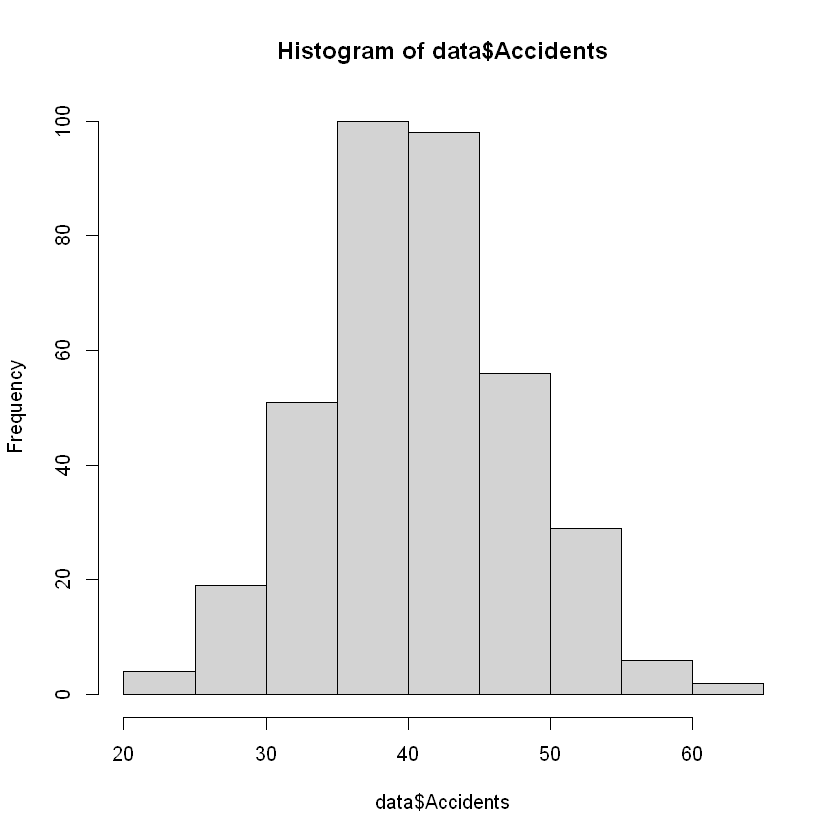

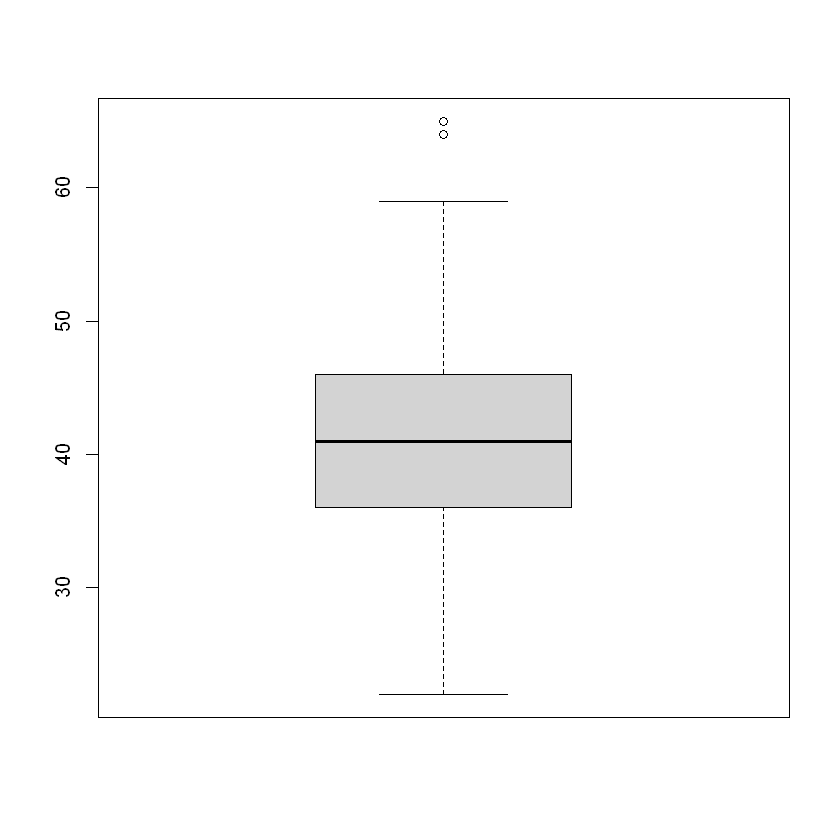

In [17]:
# reponse data distribution
hist(data$Accidents)
boxplot(data$Accidents)

Accidents seems to be normally distributed.

## Bivariate

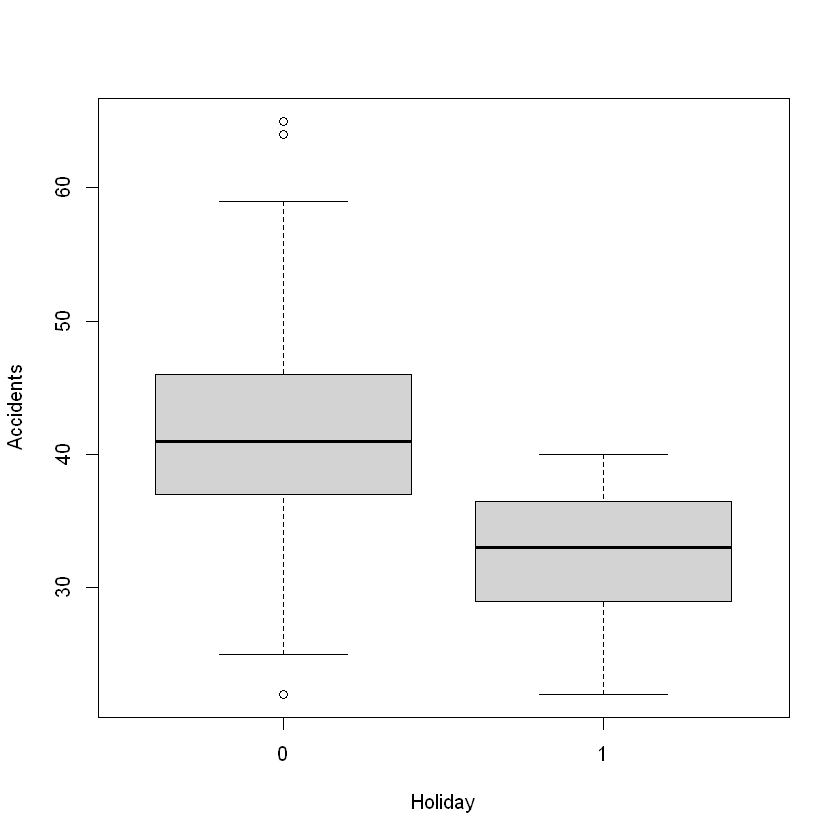

In [18]:
# boxplots of Holiday vs Accidents
par(mfrow = c(1,1))
boxplot(Accidents~Holiday, data=data)

Once can observe that days with holidays have lesser accidents than days without. However, must be pointed out that there are only 12 public holidays in 2022 indicating sample imbalance.

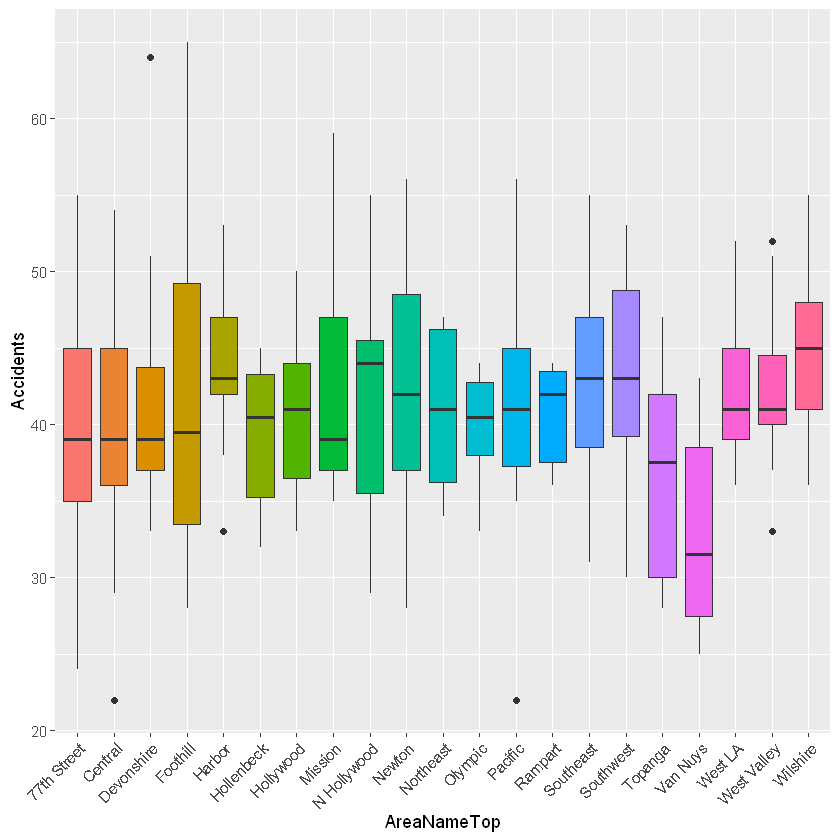

In [19]:
ggplot(data, aes(x = AreaNameTop, y = Accidents, fill=AreaNameTop)) +
geom_boxplot() +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
theme(legend.position = "none")

#ggsave("myplot.png", width = 6, height = 4, dpi = 300)

There is variability but is significant overlap

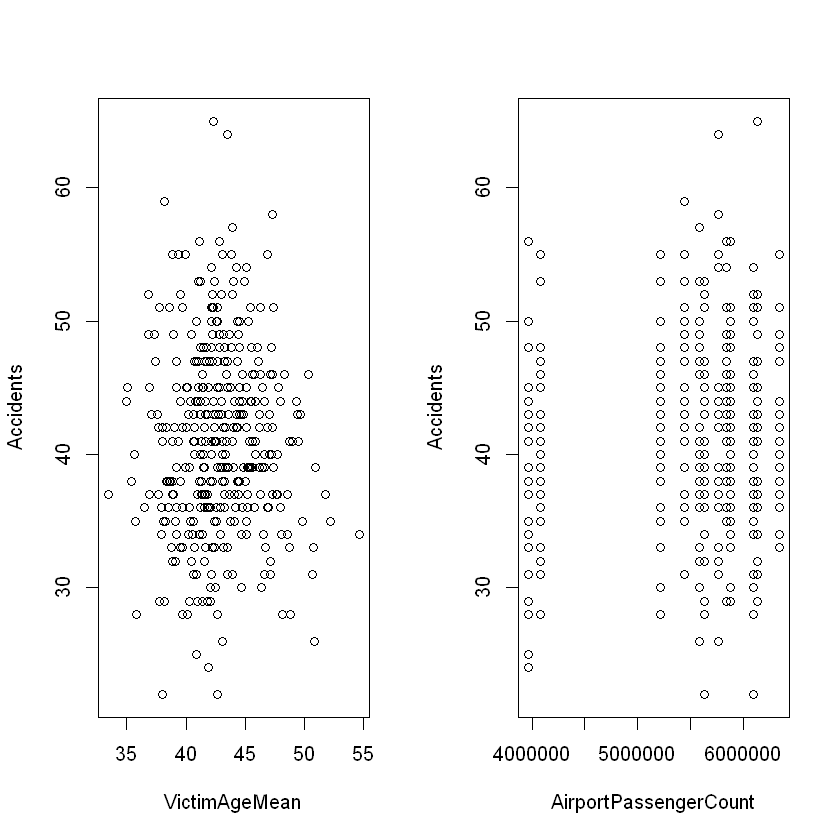

In [20]:
# plotting accidents vs categorical variables
par(mfrow = c(1,2))

plot(Accidents~VictimAgeMean, data=data)
plot(Accidents~AirportPassengerCount, data=data)

In [21]:
# Correlation matrix with numeric variables

cor(data[,c("VictimAgeMean",
            "AirportPassengerCount",
            "Accidents")])

,VictimAgeMean,AirportPassengerCount,Accidents
VictimAgeMean,1.00000000,-0.11438772,-0.01076855
AirportPassengerCount,-0.11438772,1.00000000,0.06335086
Accidents,-0.01076855,0.06335086,1.00000000


Both the quantitative variables do not seem to show any significant correlation with accidents

# Train Test Split

In [22]:
set.seed(42)

# Split the data into 80% training and 20% test sets
sample_int_ceiling <- sample.int(n = nrow(data), 
                                 size = ceiling(.80 * nrow(data)), replace = FALSE)
train_data <- data[sample_int_ceiling, ]
test_data <- data[-sample_int_ceiling, ]

dim(train_data)
dim(test_data)
head(test_data)

[1] 292   6

[1] 73  6

Date.Occurred,Holiday,AirportPassengerCount,AreaNameTop,VictimAgeMean,Accidents
<date>,<fct>,<dbl>,<fct>,<dbl>,<int>
2022-01-08,0,3966078,77th Street,42.42424,33
2022-01-15,0,3966078,Topanga,45.46154,39
2022-01-17,1,3966078,77th Street,41.91667,24
2022-01-19,0,3966078,77th Street,49.39535,43
2022-01-21,0,3966078,77th Street,44.52000,50
2022-01-23,0,3966078,77th Street,39.69697,33


# Multi Linear Regression

## Model1

### Fitting

In [23]:
model1 = lm(Accidents ~ . -Date.Occurred, 
            data=train_data)
summary(model1)


Call:
lm(formula = Accidents ~ . - Date.Occurred, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.6094  -4.6919  -0.9469   4.6057  22.8975 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.097e+01  6.631e+00   6.179 2.39e-09 ***
Holiday1               -8.318e+00  2.655e+00  -3.133  0.00192 ** 
AirportPassengerCount   4.891e-07  6.060e-07   0.807  0.42034    
AreaNameTopCentral      3.537e-02  1.550e+00   0.023  0.98181    
AreaNameTopDevonshire   1.071e+00  2.453e+00   0.437  0.66276    
AreaNameTopFoothill     1.482e+00  2.341e+00   0.633  0.52714    
AreaNameTopHarbor       3.595e+00  2.702e+00   1.331  0.18446    
AreaNameTopHollenbeck   5.172e-01  3.692e+00   0.140  0.88868    
AreaNameTopHollywood    2.596e+00  2.371e+00   1.095  0.27461    
AreaNameTopMission      5.251e+00  2.704e+00   1.942  0.05315 .  
AreaNameTopN Hollywood  3.805e-02  2.554e+00   0.015  0.98812    
AreaNameTopNewton  

Seeing the F-statistic, the overall model1 has explanability power at a level of alpha=0.05. However, a low R-squared value indicates that it is not able to explain the complete variability of the reponse variable.

In [24]:
levels(train_data$AreaNameTop)

[1] "77th Street" "Central"     "Devonshire"  "Foothill"    "Harbor"     
 [6] "Hollenbeck"  "Hollywood"   "Mission"     "N Hollywood" "Newton"     
[11] "Northeast"   "Olympic"     "Pacific"     "Rampart"     "Southeast"  
[16] "Southwest"   "Topanga"     "Van Nuys"    "West LA"     "West Valley"
[21] "Wilshire"

### GOF

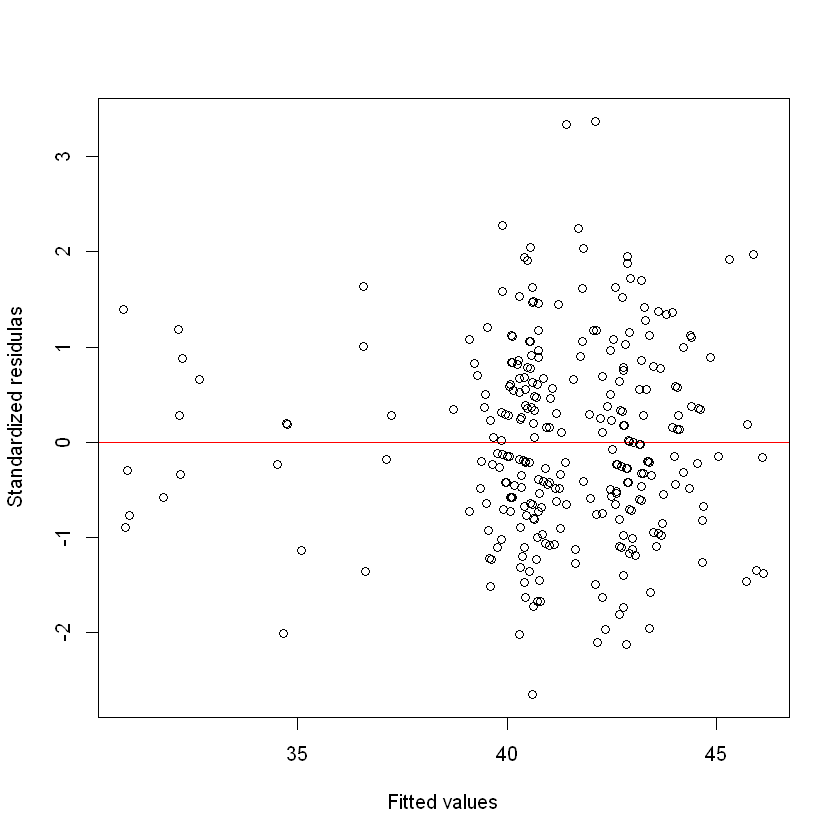

[1] 140  26

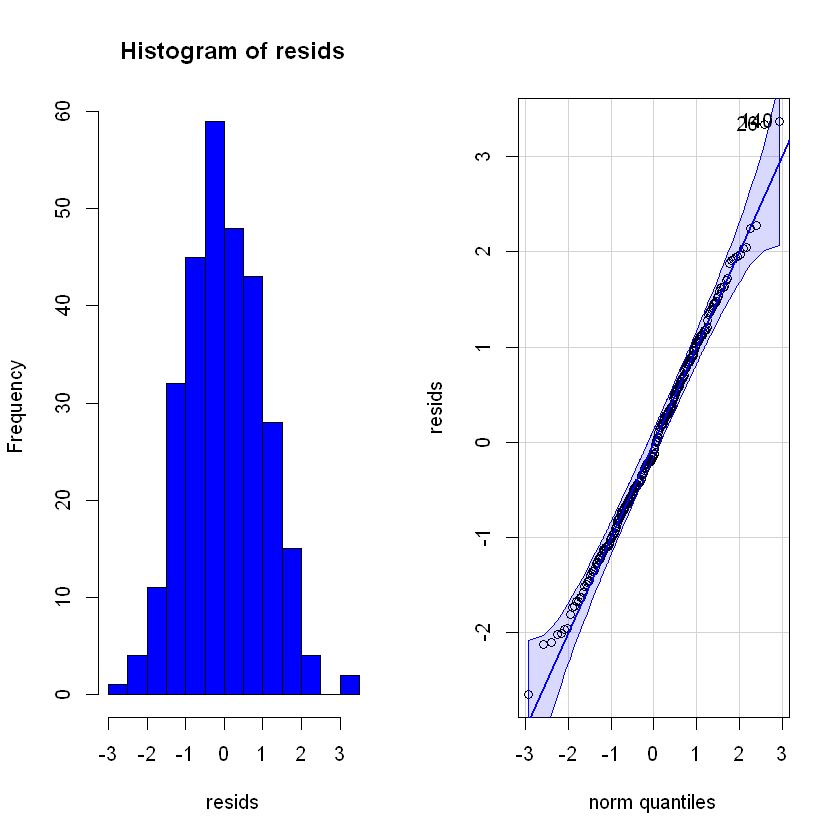

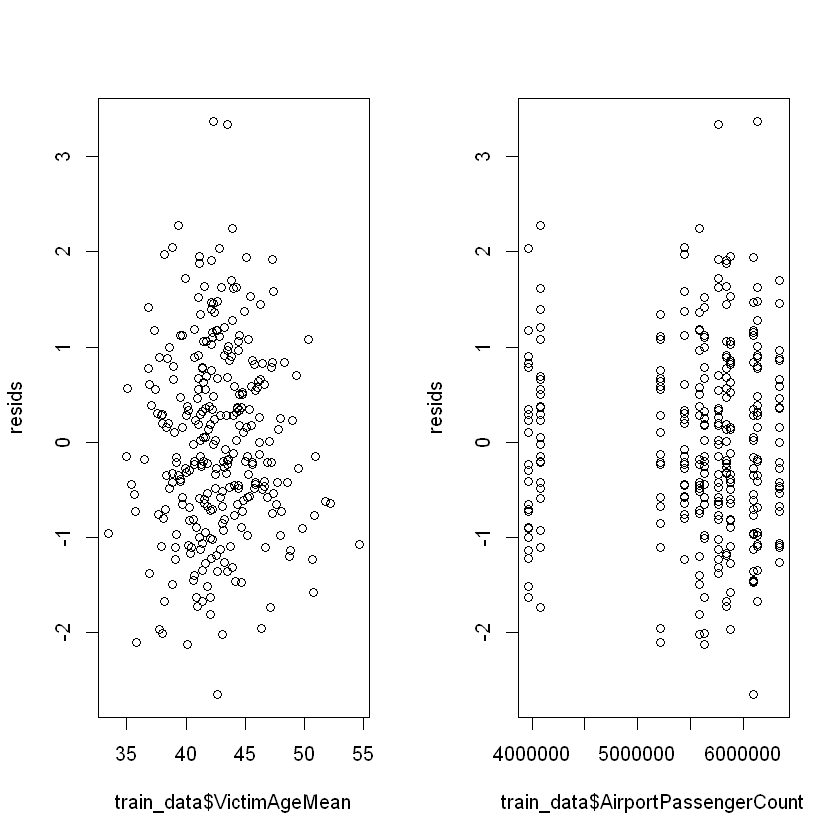

In [25]:
# Extract the standardized residuals.
resids = rstandard(model1)
# extracting fitted values
fitted = model1$fitted.values

# check for Constand Variance Assumption
plot(fitted, resids,
     xlab = "Fitted values",
     ylab = "Standardized residulas",
     abline(h=0, col = "red")
     )

# QQ and hist plot for normality assumption
par(mfrow = c(1, 2))
hist(resids, col = "blue")
qqPlot(resids, envelope = 0.95)

# checking linearity assumptions
par(mfrow = c(1,2))
plot(train_data$VictimAgeMean, resids)
plot(train_data$AirportPassengerCount, resids)

For model1, the normality and linearity assumption seem to be holding true. However, the residual vs fitted value plot shows clustering between 40-45 range. This could be because of the distribution of the train data. Otherwise, the graph shows no sign of heterskedasticity.

### Outliers

[1] "Cook's distance threshold: 0.0136986301369863"
[1] "Number of outliers: 20"


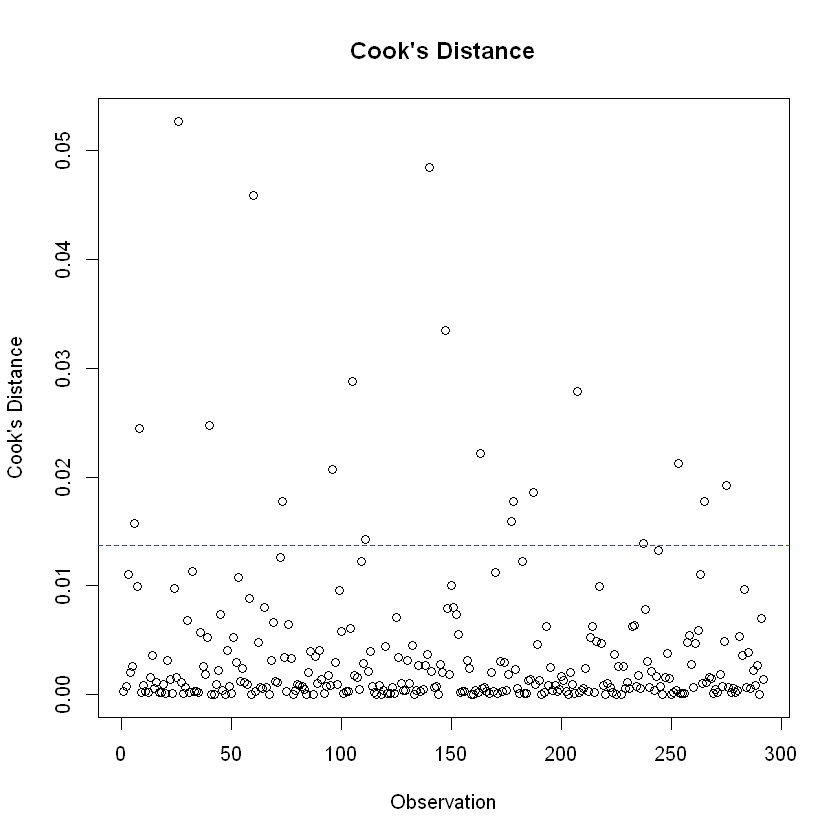

In [26]:
# Calculate Cook's distances
model1_cook <- cooks.distance(model1)

# Get the number of rows in the dataset used to create the model
cook_n <- nrow(model1$model)

# Calculate threshold
cook_threshold <- 4 / cook_n

# Plot Cook's distances
plot(model1_cook, main = "Cook's Distance", ylab = "Cook's Distance", xlab = "Observation")
abline(h = cook_threshold, col = "red", lty = 2)

# Print the calculated threshold
print(paste("Cook's distance threshold:", cook_threshold))

# Identify outliers
outliers <- which(model1_cook > cook_threshold)

# Print the number of outliers
print(paste("Number of outliers:", length(outliers)))

In [27]:
# removing outliers
train_data_cook = train_data[-outliers, ]
dim(train_data)
dim(train_data_cook)

[1] 292   6

[1] 272   6

### VIF

In [28]:
# VIF threshold.
cat("VIF threshold: ", max(10, 1/(1-summary(model1)$r.squared)), "\n")

# VIF.
vif(model1)

VIF threshold:  10 


,GVIF,Df,GVIF^(1/(2*Df))
Holiday,1.078457,1,1.038488
AirportPassengerCount,1.099372,1,1.048510
AreaNameTop,1.224167,20,1.005069
VictimAgeMean,1.073558,1,1.036126


model1 does not seem to have any multicollinearity

## Model2

### Fitting

Lets retrain the model (called model2) without the outliers

In [29]:
model2 = lm(Accidents ~ . -Date.Occurred, 
            data = train_data_cook)
summary(model2)


Call:
lm(formula = Accidents ~ . - Date.Occurred, data = train_data_cook)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.5805  -4.2077  -0.6975   4.2972  14.6727 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             3.844e+01  6.179e+00   6.221 2.08e-09 ***
Holiday1               -5.625e+00  2.509e+00  -2.242 0.025838 *  
AirportPassengerCount   6.138e-07  5.568e-07   1.102 0.271366    
AreaNameTopCentral     -4.617e-04  1.370e+00   0.000 0.999731    
AreaNameTopDevonshire  -1.445e+00  2.273e+00  -0.636 0.525501    
AreaNameTopFoothill    -4.654e-02  2.527e+00  -0.018 0.985318    
AreaNameTopHarbor       5.202e+00  2.535e+00   2.052 0.041225 *  
AreaNameTopHollenbeck   3.074e+00  3.733e+00   0.824 0.410993    
AreaNameTopHollywood    2.170e+00  2.100e+00   1.033 0.302574    
AreaNameTopMission      5.871e-01  2.732e+00   0.215 0.829993    
AreaNameTopN Hollywood -4.557e-01  2.533e+00  -0.180 0.857395    
AreaNameTopNew

### GOF

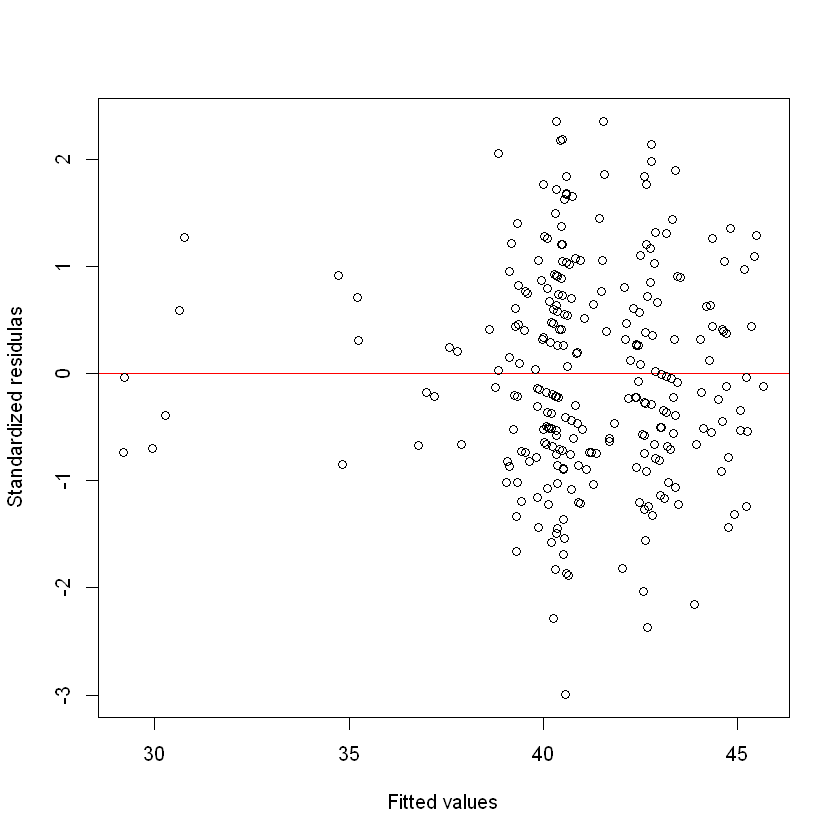

[1]  92 271

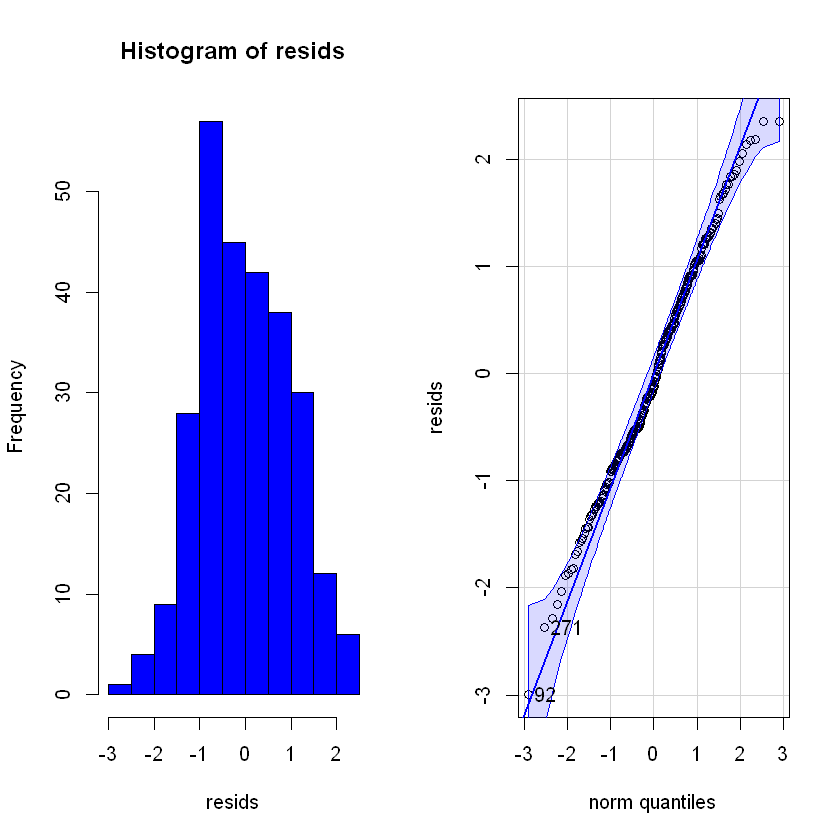

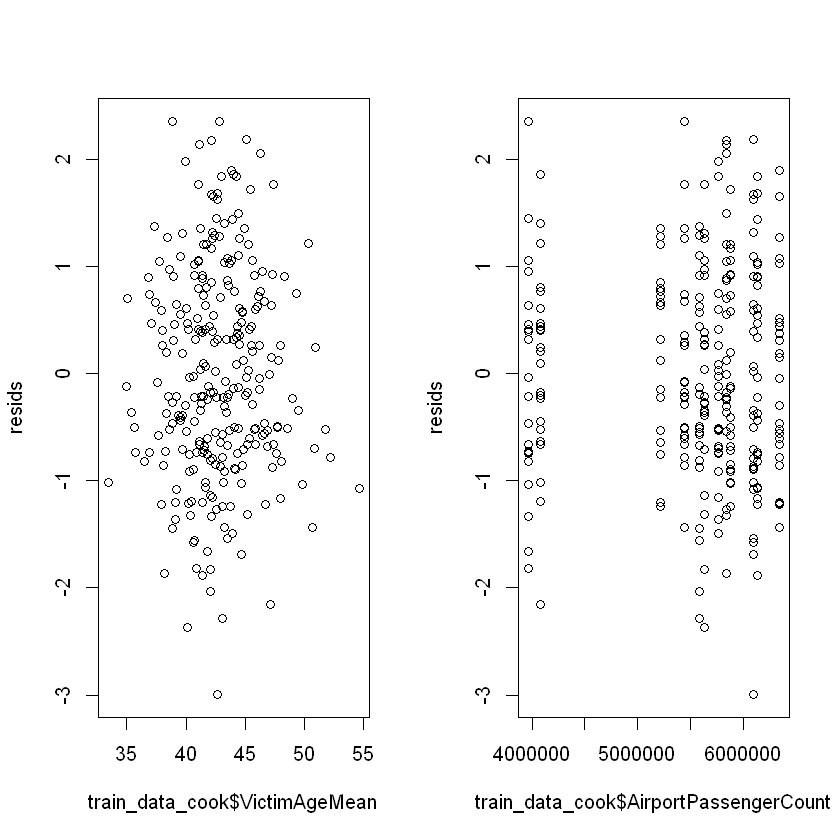

In [30]:
# Extract the standardized residuals.
resids = rstandard(model2)
# extracting fitted values
fitted = model2$fitted.values

# check for Constand Variance Assumption
plot(fitted, resids,
     xlab = "Fitted values",
     ylab = "Standardized residulas",
     abline(h=0, col = "red")
     )

# QQ and hist plot for normality assumption
par(mfrow = c(1, 2))
hist(resids, col = "blue")
qqPlot(resids, envelope = 0.95)

# checking linearity assumptions
par(mfrow = c(1,2))
plot(train_data_cook$VictimAgeMean, resids)
plot(train_data_cook$AirportPassengerCount, resids)

For model2, the linearity assumptions seems to hold true. The hist and qq plot show slight deviation from normality. Also, the constant variance assumption seems to be violated.

## Model3

### Reponse variable transformation

Optimal lambda: 0.7474747

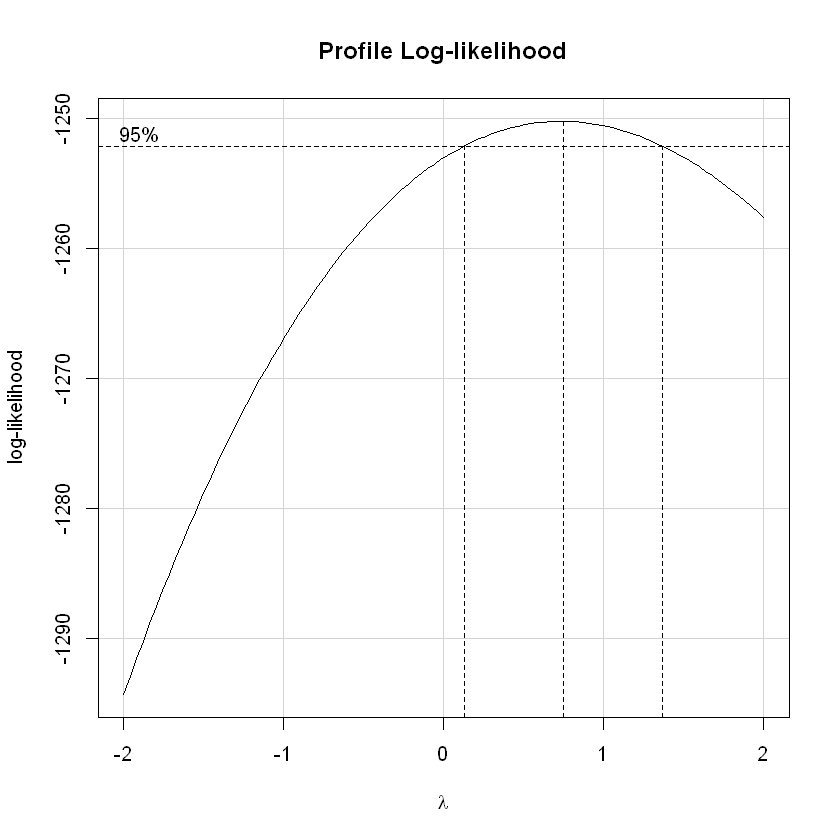

In [31]:
# Box-Cox transformation.
bc <- boxCox(model2)
lambda <- bc$x[which(bc$y == max(bc$y))]
cat("Optimal lambda:", lambda)

Box Cox test is indicating that a tranformation could be helpful. Its tranform the reponse variable by taking the its square root.

### Fitting

In [32]:
model3 = lm(sqrt(Accidents) ~ . -Date.Occurred, 
            data = train_data_cook)
summary(model3)


Call:
lm(formula = sqrt(Accidents) ~ . - Date.Occurred, data = train_data_cook)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.65088 -0.32613 -0.04414  0.33537  1.08819 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             6.179e+00  4.848e-01  12.747  < 2e-16 ***
Holiday1               -4.393e-01  1.969e-01  -2.232   0.0265 *  
AirportPassengerCount   4.753e-08  4.369e-08   1.088   0.2776    
AreaNameTopCentral     -6.593e-03  1.075e-01  -0.061   0.9512    
AreaNameTopDevonshire  -1.062e-01  1.783e-01  -0.596   0.5520    
AreaNameTopFoothill    -2.635e-03  1.982e-01  -0.013   0.9894    
AreaNameTopHarbor       4.124e-01  1.989e-01   2.073   0.0392 *  
AreaNameTopHollenbeck   2.591e-01  2.929e-01   0.885   0.3773    
AreaNameTopHollywood    1.792e-01  1.648e-01   1.088   0.2778    
AreaNameTopMission      5.945e-02  2.143e-01   0.277   0.7817    
AreaNameTopN Hollywood -2.992e-02  1.988e-01  -0.151   0.8805    
AreaName

### GOF

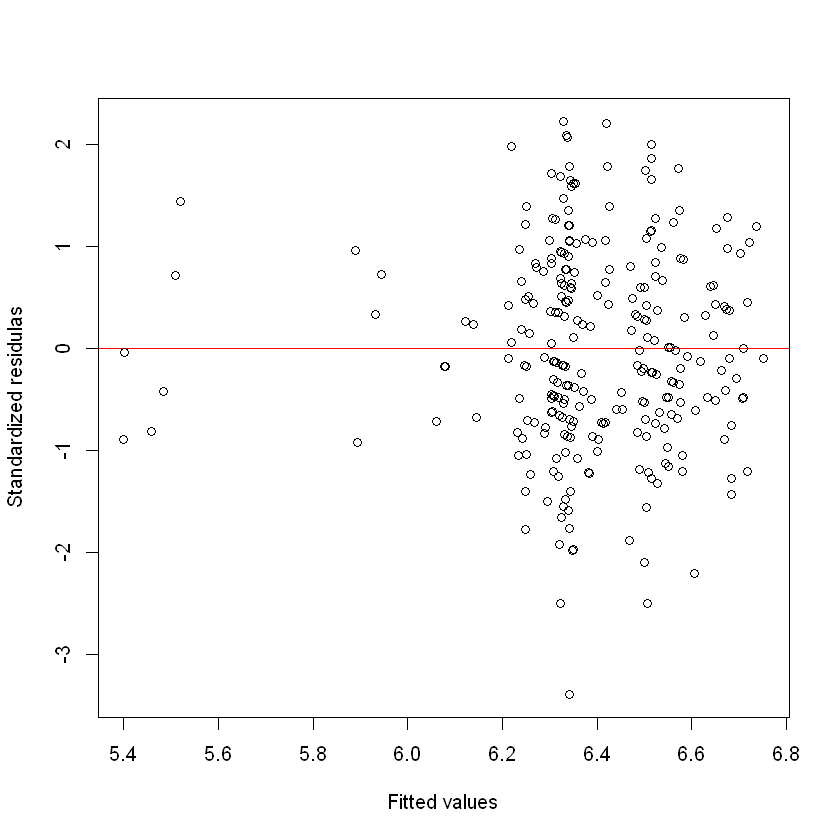

[1]  92 271

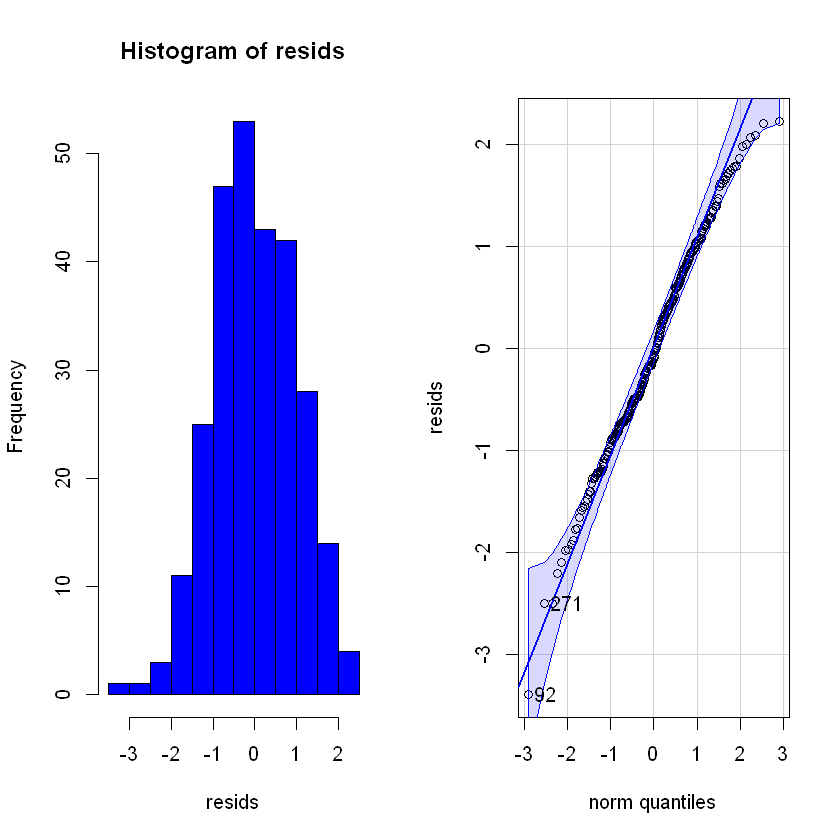

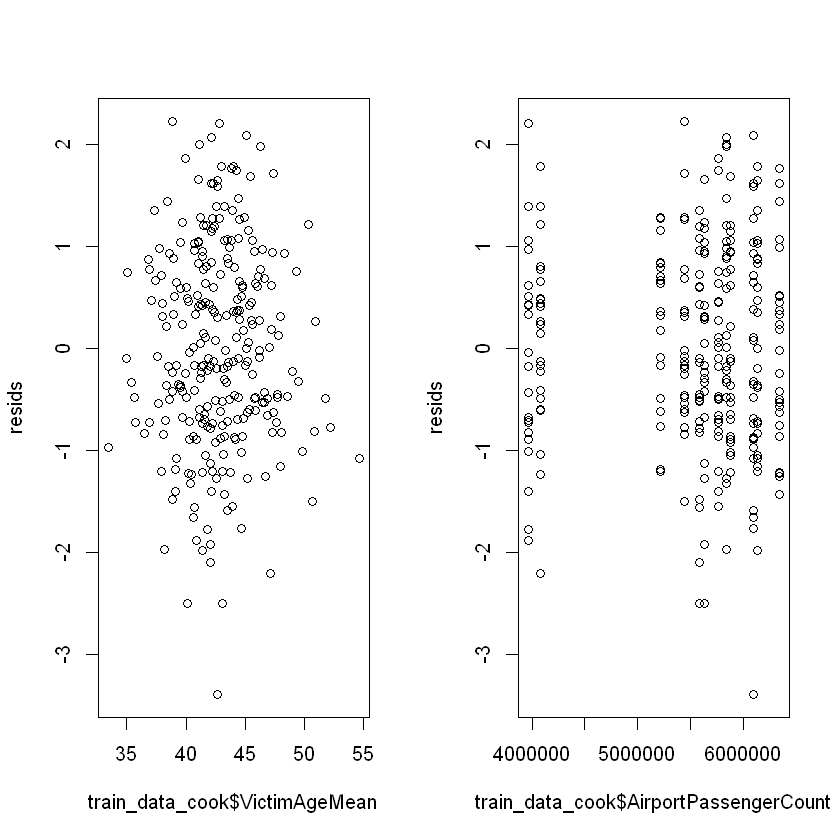

In [33]:
# Extract the standardized residuals.
resids = rstandard(model3)
# extracting fitted values
fitted = model3$fitted.values

# check for Constand Variance Assumption
plot(fitted, resids,
     xlab = "Fitted values",
     ylab = "Standardized residulas",
     abline(h=0, col = "red")
     )

# QQ and hist plot for normality assumption
par(mfrow = c(1, 2))
hist(resids, col = "blue")
qqPlot(resids, envelope = 0.95)

# checking linearity assumptions
par(mfrow = c(1,2))
plot(train_data_cook$VictimAgeMean, resids)
plot(train_data_cook$AirportPassengerCount, resids)

## Model4

### Variable selection

In [34]:
set.seed(42)

# Forward Stepwise Regression
forward_reg = step(lm(sqrt(Accidents) ~ 1, data=train_data_cook), 
                         direction="forward", 
                         scope=formula(lm(sqrt(Accidents) ~ . -Date.Occurred, data=train_data_cook)), 
                         trace=FALSE)
summary(forward_reg)


Call:
lm(formula = sqrt(Accidents) ~ Holiday + AreaNameTop, data = train_data_cook)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.63041 -0.32083 -0.02976  0.32133  1.10078 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             6.3154145  0.0635540  99.371  < 2e-16 ***
Holiday1               -0.4246574  0.1961157  -2.165   0.0313 *  
AreaNameTopCentral      0.0054132  0.1067137   0.051   0.9596    
AreaNameTopDevonshire  -0.1185414  0.1764514  -0.672   0.5023    
AreaNameTopFoothill    -0.0003945  0.1971720  -0.002   0.9984    
AreaNameTopHarbor       0.3843094  0.1971720   1.949   0.0524 .  
AreaNameTopHollenbeck   0.2408411  0.2921079   0.824   0.4104    
AreaNameTopHollywood    0.1878370  0.1643820   1.143   0.2543    
AreaNameTopMission      0.0844253  0.2129110   0.397   0.6921    
AreaNameTopN Hollywood -0.0071341  0.1971720  -0.036   0.9712    
AreaNameTopNewton       0.1732915  0.1101207   1.574   0.1168    
Area

Stepwise regression selected AreaNameTop and Holiday.

### Fitting

In [35]:
model4 = lm(sqrt(Accidents) ~ Holiday + AreaNameTop, 
            data = train_data_cook)
summary(model4)


Call:
lm(formula = sqrt(Accidents) ~ Holiday + AreaNameTop, data = train_data_cook)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.63041 -0.32083 -0.02976  0.32133  1.10078 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             6.3154145  0.0635540  99.371  < 2e-16 ***
Holiday1               -0.4246574  0.1961157  -2.165   0.0313 *  
AreaNameTopCentral      0.0054132  0.1067137   0.051   0.9596    
AreaNameTopDevonshire  -0.1185414  0.1764514  -0.672   0.5023    
AreaNameTopFoothill    -0.0003945  0.1971720  -0.002   0.9984    
AreaNameTopHarbor       0.3843094  0.1971720   1.949   0.0524 .  
AreaNameTopHollenbeck   0.2408411  0.2921079   0.824   0.4104    
AreaNameTopHollywood    0.1878370  0.1643820   1.143   0.2543    
AreaNameTopMission      0.0844253  0.2129110   0.397   0.6921    
AreaNameTopN Hollywood -0.0071341  0.1971720  -0.036   0.9712    
AreaNameTopNewton       0.1732915  0.1101207   1.574   0.1168    
Area

### GOF

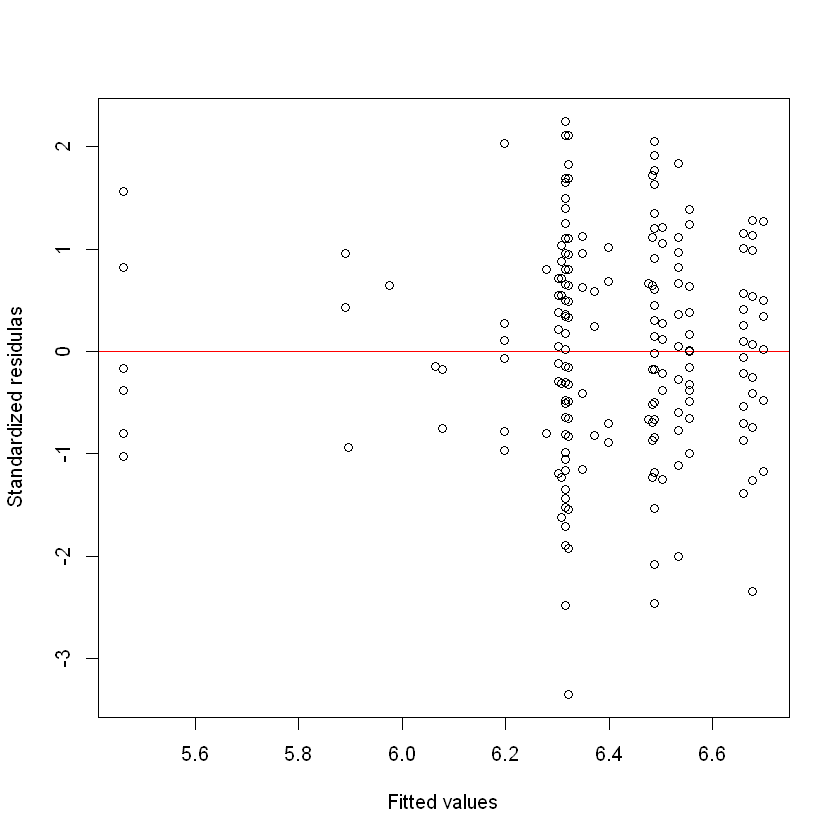

[1] 92 48

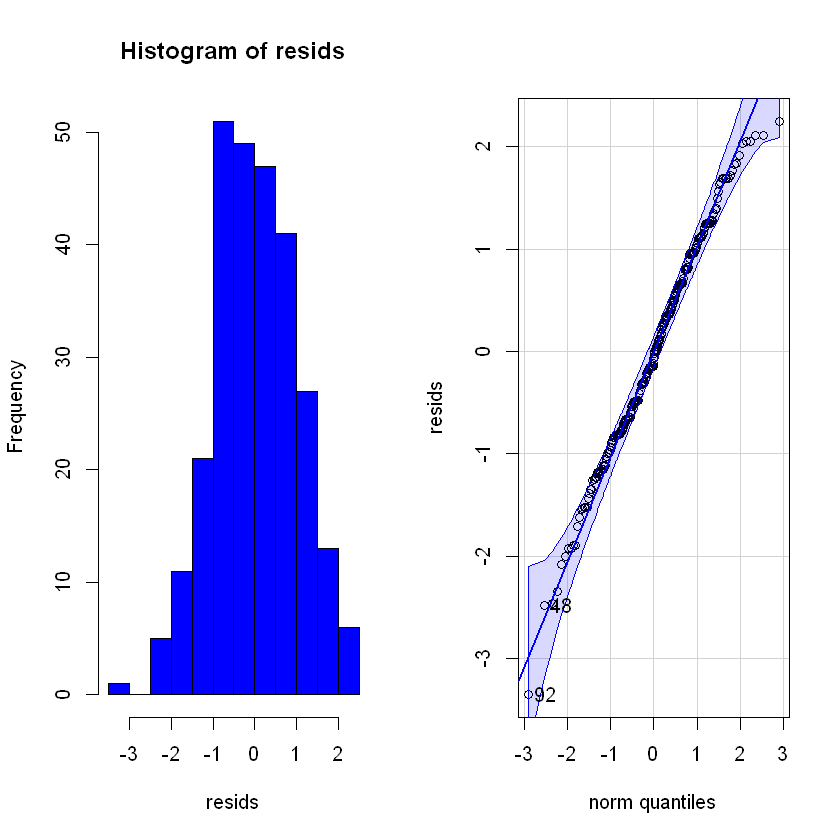

In [36]:
# Extract the standardized residuals.
resids = rstandard(model4)
# extracting fitted values
fitted = model4$fitted.values

# check for Constand Variance Assumption
plot(fitted, resids,
     xlab = "Fitted values",
     ylab = "Standardized residulas",
     abline(h=0, col = "red")
     )

# QQ and hist plot for normality assumption
par(mfrow = c(1, 2))
hist(resids, col = "blue")
qqPlot(resids, envelope = 0.95)

# checking linearity assumptions
#par(mfrow = c(1,2))
#plot(train_data_cook$VictimAgeMean, resids)
#plot(train_data_cook$AirportPassengerCount, resids)

# Poisson Regression

## Model5

### Fitting

In [37]:
model5 = glm(Accidents ~. -Date.Occurred, data=train_data, family="poisson")
summary(model5)


Call:
glm(formula = Accidents ~ . - Date.Occurred, family = "poisson", 
    data = train_data)

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             3.712e+00  1.452e-01  25.561  < 2e-16 ***
Holiday1               -2.184e-01  6.317e-02  -3.457 0.000546 ***
AirportPassengerCount   1.196e-08  1.335e-08   0.896 0.370164    
AreaNameTopCentral      9.234e-04  3.432e-02   0.027 0.978535    
AreaNameTopDevonshire   2.652e-02  5.377e-02   0.493 0.621899    
AreaNameTopFoothill     3.640e-02  5.094e-02   0.715 0.474893    
AreaNameTopHarbor       8.634e-02  5.776e-02   1.495 0.134988    
AreaNameTopHollenbeck   1.292e-02  8.137e-02   0.159 0.873869    
AreaNameTopHollywood    6.315e-02  5.168e-02   1.222 0.221731    
AreaNameTopMission      1.239e-01  5.708e-02   2.171 0.029896 *  
AreaNameTopN Hollywood  1.296e-03  5.635e-02   0.023 0.981645    
AreaNameTopNewton       5.606e-02  3.463e-02   1.619 0.105524    
AreaNameTopNortheast    3.286e-

In [38]:
1-pchisq(model5$null.deviance - model5$deviance,
 model5$df.null - model5$df.resid)

[1] 0.0007470639

The p-value for the chi-square test is close to 0, indicating that the overall regression is significant and model5 has explanatory power

### GOF

[1] 140  26

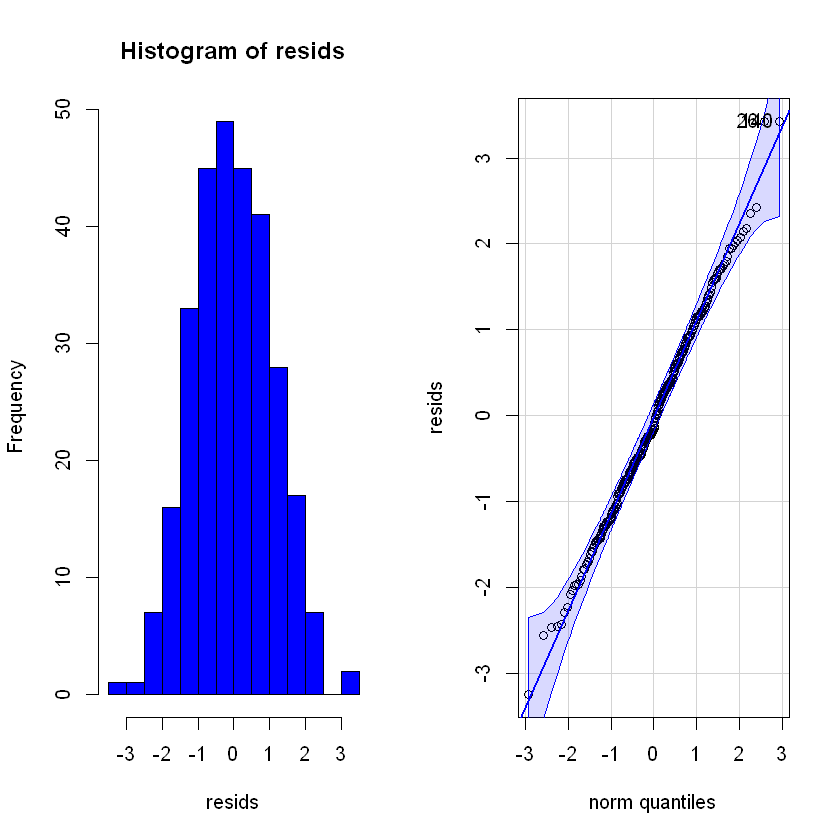

In [39]:
# Extract the standardized residuals.
resids = rstandard(model5)

# QQ and hist plot for normality assumption
par(mfrow = c(1, 2))
hist(resids, col = "blue")
qqPlot(resids, envelope = 0.95)

The residuals seem to be normally distributed.

In [40]:
# chi-squared test for GOF
with(model5, cbind(res.deviance = deviance,
    df = df.residual,
    p = pchisq(deviance, df.residual, lower.tail = FALSE)))

res.deviance,df,p
330.1686,268,0.005700557


Since p < 0.05, indicating that the model is not a good fit.

### Check for over dispersion

In [41]:
m = model5

# with deviance residuals
wdf_d <- m$df.residual
dev_d <- m$deviance
dev_d/wdf_d

# with pearson residuals
wdf_p <- m$df.residual
dev_p <- sum(residuals(m, type='pearson')^2)
dev_p/wdf_p

[1] 1.231972

[1] 1.232356

Keeping the threshold as 2, there seems to be no over dispersion.

### Outliers

In [42]:
# Assuming GOF: Deviance ~ N(0,1).

#  Evaluate Deviance residuals vs the Normal quantile with prob = 0.99995.
dev_residuals = residuals(model5, type = "deviance")
outliers = which(abs(dev_residuals) > qnorm(0.99995))
length(outliers)

[1] 0

Assuming goodness of fit (Deviance coming from a N(0,1) ) and comparing residuals vs the quantile of the 0.99995 tail means that the probability of a residual to be larger than this quantile is 0.00001, which is a very small probability. The results indicate that there are no outliers.

## Model6

### Variable selection

In [43]:
set.seed(42)
#glm(Accidents ~. -Date.Occurred, data=train_data, family="poisson")
# Forward Stepwise Regression
forward_reg = step(glm(Accidents ~ 1, data=train_data, family="poisson"), 
                         direction="forward", 
                         scope=formula(glm(Accidents ~. -Date.Occurred, data=train_data, family="poisson")), 
                         trace=FALSE)
summary(forward_reg)


Call:
glm(formula = Accidents ~ Holiday, family = "poisson", data = train_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.72374    0.00922 403.867  < 2e-16 ***
Holiday1    -0.19371    0.06122  -3.164  0.00156 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 380.86  on 291  degrees of freedom
Residual deviance: 370.20  on 290  degrees of freedom
AIC: 1993.3

Number of Fisher Scoring iterations: 4


### Fitting

In [44]:
model6 = glm(Accidents ~ Holiday, data=train_data, family="poisson")
summary(model6)


Call:
glm(formula = Accidents ~ Holiday, family = "poisson", data = train_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.72374    0.00922 403.867  < 2e-16 ***
Holiday1    -0.19371    0.06122  -3.164  0.00156 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 380.86  on 291  degrees of freedom
Residual deviance: 370.20  on 290  degrees of freedom
AIC: 1993.3

Number of Fisher Scoring iterations: 4


In [45]:
1-pchisq(model6$null.deviance - model6$deviance,
 model6$df.null - model6$df.resid)

[1] 0.001096736

The p-value for the chi-square test is close to 0, indicating that the overall regression is significant and model6 has explanatory power

### GOF

[1] 140  99

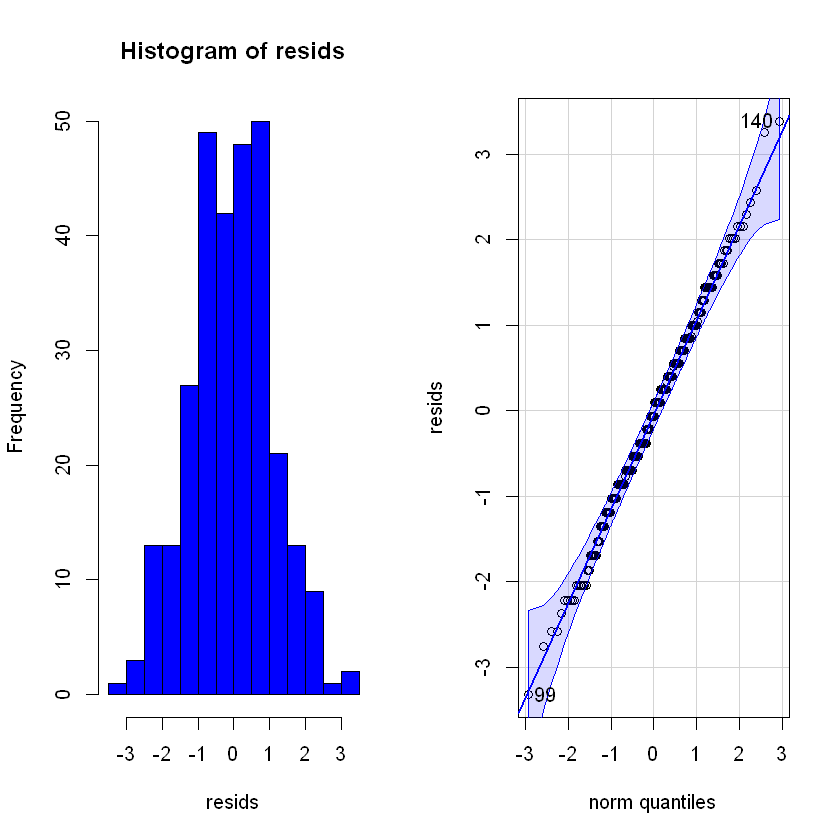

In [46]:
# Extract the standardized residuals.
resids = rstandard(model6)

# QQ and hist plot for normality assumption
par(mfrow = c(1, 2))
hist(resids, col = "blue")
qqPlot(resids, envelope = 0.95)

In [47]:
# chi-squared test for GOF
with(model6, cbind(res.deviance = deviance,
    df = df.residual,
    p = pchisq(deviance, df.residual, lower.tail = FALSE)))

res.deviance,df,p
370.2032,290,0.0009940879


Model is not a good fit at alpha = 0.05 level

### Check for over dispersion

In [48]:
m = model6

# with deviance residuals
wdf_d <- m$df.residual
dev_d <- m$deviance
dev_d/wdf_d

# with pearson residuals
wdf_p <- m$df.residual
dev_p <- sum(residuals(m, type='pearson')^2)
dev_p/wdf_p

[1] 1.276563

[1] 1.271369

# Prediction

In [49]:
# predicting with test data

# Mean squared prediction error (MSPE).
mse_fun <- function(pred, dat) {
    mean((pred - dat)^2)
}

# Mean absolute prediction error (MAE).
mae_fun <- function(pred, dat) {
    mean(abs(pred - dat))
}
# Mean absolute percentage error (MAPE).
mape_fun <- function(pred, dat) {
    mean(abs(pred - dat) / abs(dat))
}

# Precision measure (PM).
pm_fun <- function(pred, dat) {
    sum((pred - dat)^2) / sum((dat - mean(dat))^2)
}

# custom function to return accuracy measurements
custom_pred_fun = function(model, 
                           newdata, 
                           Poisson=FALSE, 
                           tranformation=FALSE) {

    if (Poisson == TRUE) {
    # Poisson
    pred_y = predict(model, newdata=test_data, type="response")
    } else {
    # MLR
    pred_y = predict(model, newdata=test_data)
    }
    
    if (tranformation == TRUE) {
    # tranformed
    pred_y = pred_y**2
    } else {
    pred_y = pred_y
    }
    
    print(paste("MSE:", round(mse_fun(pred_y, test_data$Accidents),2)))
    print(paste("MAE:", round(mae_fun(pred_y, test_data$Accidents),2)))
    print(paste("MAPE:", round(mape_fun(pred_y, test_data$Accidents),2)))
    print(paste("PM:", round(pm_fun(pred_y, test_data$Accidents),2)))
}

In [50]:
# Model1
print("Model1")
custom_pred_fun(model1, test_data)

# Model2
print("Model2")
custom_pred_fun(model2, test_data)

# Model3
print("Model3")
custom_pred_fun(model3, test_data, tranformation=TRUE)

# Model4
print("Model4")
custom_pred_fun(model4, test_data, tranformation=TRUE)

# Model5
print("Model5")
custom_pred_fun(model5, test_data, ,Poisson=TRUE)

# Model6
print("Model6")
custom_pred_fun(model6, test_data, ,Poisson=TRUE)

[1] "Model1"
[1] "MSE: 31.54"
[1] "MAE: 4.65"
[1] "MAPE: 0.12"
[1] "PM: 0.86"
[1] "Model2"
[1] "MSE: 34.47"
[1] "MAE: 4.85"
[1] "MAPE: 0.12"
[1] "PM: 0.94"
[1] "Model3"
[1] "MSE: 34.49"
[1] "MAE: 4.84"
[1] "MAPE: 0.12"
[1] "PM: 0.94"
[1] "Model4"
[1] "MSE: 34.2"
[1] "MAE: 4.77"
[1] "MAPE: 0.12"
[1] "PM: 0.93"
[1] "Model5"
[1] "MSE: 31.74"
[1] "MAE: 4.67"
[1] "MAPE: 0.12"
[1] "PM: 0.86"
[1] "Model6"
[1] "MSE: 31.85"
[1] "MAE: 4.59"
[1] "MAPE: 0.12"
[1] "PM: 0.87"


# Cross Validation

## Model4

In [51]:
set.seed(42)

my_metrics <- function(data, lev = NULL, model = NULL) {
  obs  <- data$obs
  pred <- data$pred

  mape = mean(abs(pred - obs) / abs(obs))
  pm = sum((pred - obs)^2) / sum((obs - mean(obs))^2)
  
  c(MAPE = mape, PM = pm)
}

ctrl <- trainControl(
  method = "cv",
  number = 10,
  summaryFunction = my_metrics
)

model_cv <- train(
  sqrt(Accidents) ~ Holiday + AreaNameTop, 
  data = data,
  method = "lm",
  metric = "MAPE",   # choose the metric used for model selection
  trControl = ctrl
)

mean(model_cv$resample$MAPE)
mean(model_cv$resample$PM)
model_cv$resample

[1] 0.07100184

[1] 1.012444

MAPE,PM,Resample
<dbl>,<dbl>,<chr>
0.07381481,0.9567252,Fold01
0.08447122,1.0920645,Fold02
0.06294371,1.1302906,Fold03
0.06166948,0.9444073,Fold04
0.07216087,0.9812179,Fold05
0.07600112,0.9040623,Fold06
0.06087883,0.9931337,Fold07
0.07411926,1.0605978,Fold08
0.07097032,0.8648649,Fold09
